## OCR 모델 비교하기

##### 기획 : 거리의 간판이미지를 인식하고 상호명과 관련된 정보를 데이터화 하고자 함 

#### 라이브러리 로드

In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import keras_ocr


#### 이미지 업로드 및 해당 업로드 된 이미지 경로 설정

In [2]:
data_path = os.getenv('HOME')+ '/aiffel/ocr_python/image'
data_path


'/aiffel/aiffel/ocr_python/image'

In [3]:
# 입력 이미지 경로 
file_list = os.listdir(data_path)
file_path = [data_path+'/'+name for name in file_list]
file_path = sorted(file_path)
file_path

['/aiffel/aiffel/ocr_python/image/1.png',
 '/aiffel/aiffel/ocr_python/image/10.png',
 '/aiffel/aiffel/ocr_python/image/2.png',
 '/aiffel/aiffel/ocr_python/image/3.png',
 '/aiffel/aiffel/ocr_python/image/4.png',
 '/aiffel/aiffel/ocr_python/image/5.png',
 '/aiffel/aiffel/ocr_python/image/6.png',
 '/aiffel/aiffel/ocr_python/image/7.png',
 '/aiffel/aiffel/ocr_python/image/8.png',
 '/aiffel/aiffel/ocr_python/image/9.png']

#### 로드 이미지 확인하기

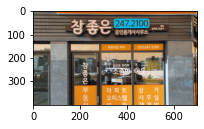

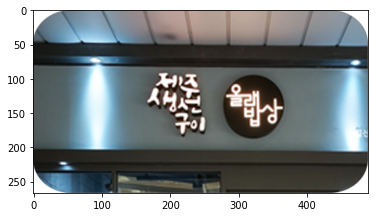

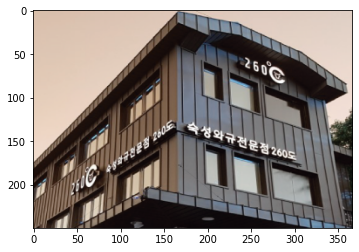

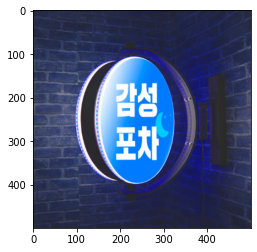

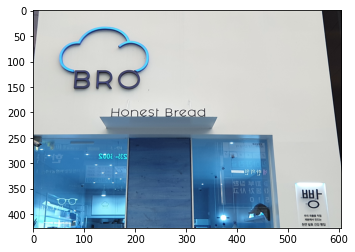

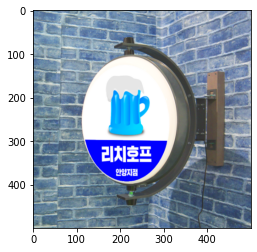

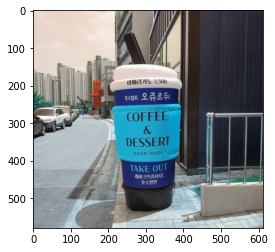

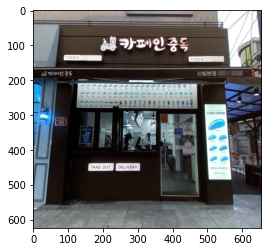

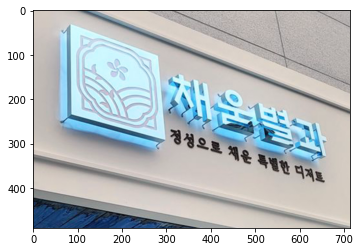

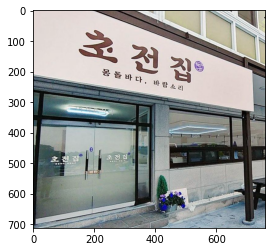

In [4]:
rows = 5
cols = 2
fig = plt.figure(figsize=(20,10))
for idx, path in enumerate(file_path, 1):
    ax = fig.add_subplot(rows, cols, idx)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    plt.imshow(img)
    
    plt.show()

#### 문자 인식 함수 선언

In [5]:
def detect_text(path):
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()
    
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
    
    image = vision.Image(content=content)
    
    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    #     for text in texts:
    print('\n"{}"'.format(texts[0].description))
    
    vertices = (['({},{})'.format(vertex.x, vertex.y) for vertex in texts[0].bounding_poly.vertices])
    
    print('bounds: {}'.format(','.join(vertices)))
    
    if response.error.message:
        raise Exception(
        '{}\nFor more info on erroe messages, check:' 
        'https://cloud.google.com/apis/design/errors'.format(
        response.error.message))
    
    return texts[0].description

In [6]:
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

total 700
-rw-r--r-- 1 root root 693875 Jan  9 14:08 'Exp#_a_15_OCR모델 비교하기.ipynb'
-rw-r--r-- 1 root root   2300 Jan  9 11:20  googleapi.json
drwxr-xr-x 2 root root   4096 Jan  9 14:08  image
drwxr-xr-x 2 root root   4096 Jan  9 11:42  output
drwxr-xr-x 4 root root   4096 Jan  9 11:41  tesseract
drwxr-xr-x 2 root root   4096 Jan  9 12:39 'Untitled Folder'


### keras-ocr 사용

In [7]:

pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [8]:
images = [keras_ocr.tools.read(path) for path in file_path]
prediction_groups = [pipeline.recognize({path}) for path in file_path]

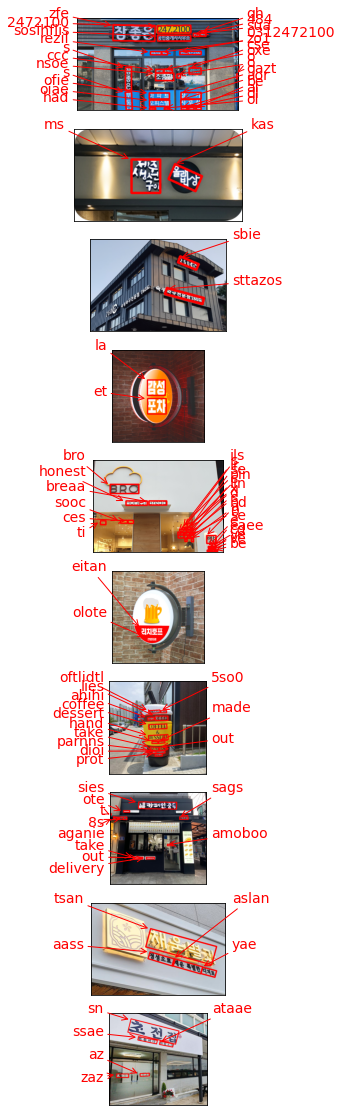

In [9]:
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx],
                                   predictions=prediction_groups[idx][0], ax=ax)

### Tesseract

In [22]:
import pytesseract
from PIL import Image
from pytesseract import Output

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path, output_path='./output', lang='kor'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)
    
    recognized_data = pytesseract.image_to_data(
        image, lang=lang,
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
        
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
#             print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
        
    return cropped_image_path_list
    
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/tesseract/kor'
    
    
tesseract_result_path = []
for path in range(3):
    print(file_path[path])
    image_path_list = crop_word_regions(file_path[path])
    tesseract_result_path.extend(image_path_list)

/aiffel/aiffel/ocr_python/image/1.png
/aiffel/aiffel/ocr_python/image/10.png
/aiffel/aiffel/ocr_python/image/2.png


In [23]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/googleapi.json'


In [24]:
def recognize_images(cropped_image_path_list, lang='kor'):
    custom_oem_psm_config = r' --oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang=lang,
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print('Done')
#     return recognized_data


recognize_images(tesseract_result_path)


『 」

: 「

4

해

나

-

“”

| )

기

수 @역

이이

개사사무소


라오

[1


『 」

: 「

4

해

나

-


Done


## 회고

- 구글 API는 키문제로 직접 테스트를 하지 못했으나 다른 사례를 보면 가장 높은 정확도를 가지고 있다고 보여짐
- 간판 글씨를 해당 문자가 있는 곳을 대체로 2모델 모두 정확히 인식하는 것으로 보여짐
- Tesseract의 경우 한글도 지원하여 한글 간판도 테스트 할 수 있었음 
- Tesseract는 오픈 소스로 활용하여 좀 더 다양한 분야에 활용할 수 있는 기회가 있다고 생각됨